# Training Capsule Network on CIFAR10

Harder than MNIST!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import optim

from datasets import get_cifar10_dataset, get_data_loader
from utils import *

from capsnet import *

Files already downloaded and verified
Files already downloaded and verified


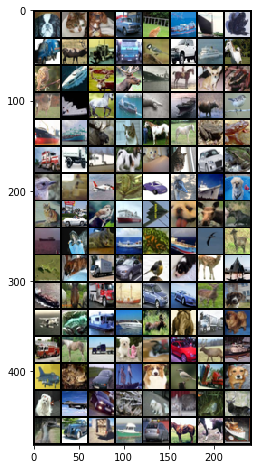

In [13]:
trainset, testset = get_cifar10_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [9]:
net = CapsuleNetwork(img_colors=3, primary_caps=64).cuda()
decoder = CapsuleDecoder(img_colors=3, reconstruction=True, mask_incorrect=True).cuda()
class CapsModel(nn.Module):
    def __init__(self, net, decoder):
        super().__init__()
        self.net = net
        self.decoder = decoder
    
    def forward(self, x, y=None):
        d_caps = self.net(x)
        probs, reconstructions = self.decoder(d_caps, y)
        return probs, reconstructions
caps_model = CapsModel(net, decoder)

print(count_params(net))
print(count_params(caps_model))

caps_loss = CapsuleLoss()
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

13628928
16647472


In [7]:
MODEL_PATH = 'capsnet_cifar.pth.tar'

In [10]:
caps_trainer.load_checkpoint(MODEL_PATH)

In [ ]:
caps_trainer.run(epochs=5)
caps_trainer.save_checkpoint(MODEL_PATH)

[*] Training for 5 epochs
[*] Batch 0, Loss: 78.388, Acc: 0.430
[*] Batch 50, Loss: 76.550, Acc: 0.523
[*] Batch 100, Loss: 77.384, Acc: 0.484
[*] Batch 150, Loss: 77.902, Acc: 0.461


In [ ]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data)